
# Audio Programming Tutorial (EECS 183/283A)

Welcome! In this tutorial, you will explore the fundamentals of audio processing and build an speech classifier from scratch.

## What You'll Learn:
1. **Load and manipulate audio** - Read audio files, convert to mono, resample
2. **Visualize waveforms** - See what sound looks like in the time domain
3. **Linear spectrogram (STFT)** - Understand frequency content over time
4. **Mel spectrogram** - Learn perceptually-motivated audio features
5. **Audio tokenization** - Explore discrete representations with EnCodec
6. **Speech classification** - Train a CNN to recognize spoken commands

## Think About:
- How do computers "hear" audio?
- Why do we convert audio to spectrograms instead of using raw waveforms?
- What makes audio different from images?


## 0. Setup

In [ ]:

# If needed, uncomment to install (recommended in a fresh environment):
# !pip install torch torchaudio librosa matplotlib numpy scikit-learn transformers

import numpy as np
import torch, torchaudio
import librosa
import matplotlib.pyplot as plt

print("torch:", torch.__version__)
print("torchaudio:", torchaudio.__version__)
print("librosa:", librosa.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


torch: 2.9.0+cu128
torchaudio: 2.9.0+cu128
librosa: 0.11.0


device(type='cuda')

## 1. Load audio & basic operations

In [2]:
from pathlib import Path
import torchaudio
from IPython.display import Audio

# Demo with a short sample.
# You can replace "example.wav" with your own file name.
tmpfile = Path("example.wav")

# 1. Load audio from file
wave, sr = torchaudio.load(str(tmpfile))
print("Wave shape:", tuple(wave.shape), "Sample rate:", sr, "Duration (s):", wave.size(-1)/sr)
Audio(data=wave, rate=sr)

Wave shape: (2, 89280) Sample rate: 24000 Duration (s): 3.72


In [3]:
# 2. Convert to mono
# The audio may have multiple channels (e.g., stereo). 
# For many audio processing tasks, we work with mono audio.
# Let's convert it to mono by averaging the channels if there are more than one.

if wave.size(0) > 1:
    wave = wave.mean(0, keepdim=True)

print("Wave shape after mono conversion:", tuple(wave.shape))
Audio(data=wave, rate=sr)


Wave shape after mono conversion: (1, 89280)


In [4]:
# 3. Resample to a target sample rate
# Audio can come with different sample rates.
# For consistency, we often resample it to a target sample rate.
# Let's resample our audio to 16000 Hz.

TARGET_SR = 16000
if sr != TARGET_SR:
    resampler = torchaudio.transforms.Resample(sr, TARGET_SR)
    wave = resampler(wave)
    sr = TARGET_SR

print("Wave shape after resampling:", tuple(wave.shape), "New sample rate:", sr)
Audio(data=wave, rate=sr)


Wave shape after resampling: (1, 59520) New sample rate: 16000


## 2. Visualize waveform

Audio in the **time domain** shows amplitude changes over time. Let's plot what we just loaded.

**Question:** What does the y-axis represent? What about the x-axis?

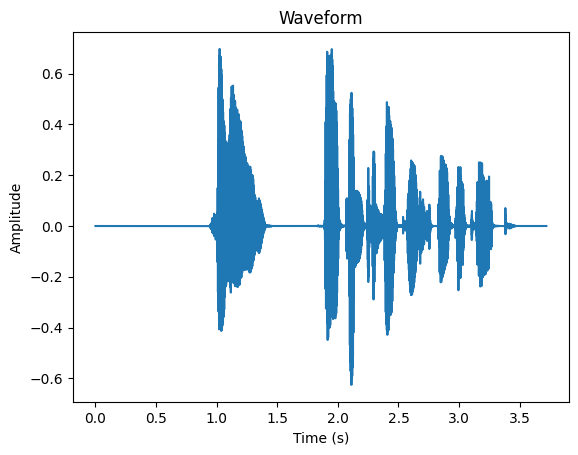

In [5]:

x = wave.squeeze().numpy()
t = np.arange(len(x)) / sr

plt.figure()
plt.plot(t, x)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()


## 3. Linear spectrogram (STFT)

The **Short-Time Fourier Transform (STFT)** breaks audio into small time windows and computes the frequency content of each window. This gives us a 2D representation: time × frequency.

**Key parameters:**
- `n_fft`: FFT size (determines frequency resolution)
- `hop_length`: How much we slide the window (determines time resolution)
- `win_length`: Window size for analysis

**Questions:**
- Why can't we see both time and frequency in a single waveform plot?
- What happens if you increase `n_fft`? Try it!
- What's the tradeoff between time and frequency resolution?

Spectrogram shape: (1, 513, 233) (C,F,T)


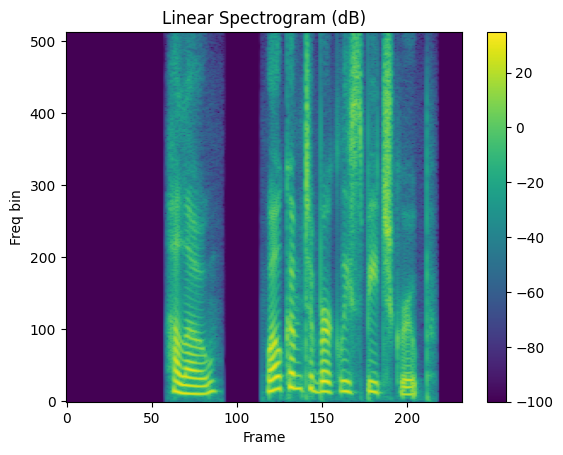

In [6]:

n_fft = 1024
hop_length = 256
win_length = 1024

spec = torchaudio.transforms.Spectrogram(
    n_fft=n_fft, hop_length=hop_length, win_length=win_length, power=2.0
)(wave)                                   # [1, F, T_frames]

spec_db = 10.0 * torch.log10(spec + 1e-10)

print("Spectrogram shape:", tuple(spec.shape), "(C,F,T)")

plt.figure()
plt.imshow(spec_db.squeeze().numpy(), origin="lower", aspect="auto")
plt.xlabel("Frame")
plt.ylabel("Freq bin")
plt.title("Linear Spectrogram (dB)")
plt.colorbar()
plt.show()


## 4. Mel spectrogram (log / dB)

Human perception of sound is **not linear in frequency**. We're more sensitive to differences at low frequencies (e.g., 100 Hz vs 200 Hz) than high frequencies (e.g., 10 kHz vs 10.1 kHz).

The **Mel scale** mimics human hearing by:
- Spacing frequency bins closer together at low frequencies
- Spacing them further apart at high frequencies

This gives us more meaningful features for machine learning!

**Questions:**
- Why use 64 mel bins instead of 513 frequency bins from STFT?
- What do you think "dB" (decibel) scale does?
- How is this similar to how our eyes perceive light vs darkness?

Mel shape: (1, 64, 233) (C,M,T)


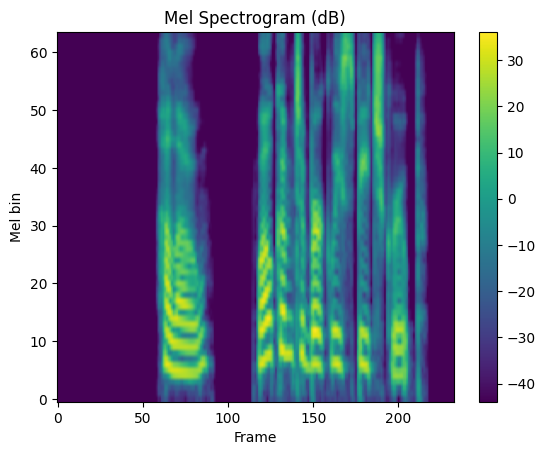

In [7]:

n_mels = 64

mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr, n_fft=n_fft, hop_length=hop_length,
    win_length=win_length, n_mels=n_mels, f_min=0.0, f_max=sr/2
)(wave)                                   # [1, M, T_frames]

mel_db = torchaudio.transforms.AmplitudeToDB(top_db=80)(mel)

print("Mel shape:", tuple(mel_db.shape), "(C,M,T)")

plt.figure()
plt.imshow(mel_db.squeeze().numpy(), origin="lower", aspect="auto")
plt.xlabel("Frame")
plt.ylabel("Mel bin")
plt.title("Mel Spectrogram (dB)")
plt.colorbar()
plt.show()


## 5. Parameter sensitivity (quick test)

Let's experiment with different parameters to see how they affect the spectrogram!

**Experiment:**
- Try different `hop_length` values: smaller = more time frames, larger = fewer frames
- Try different `n_mels` values: more bins = finer frequency detail

**Question:**
- Which setting gives you the most "useful" representation?
- What would happen if `hop_length` is too large?
- Why might we want fewer mel bins for machine learning (despite losing detail)?

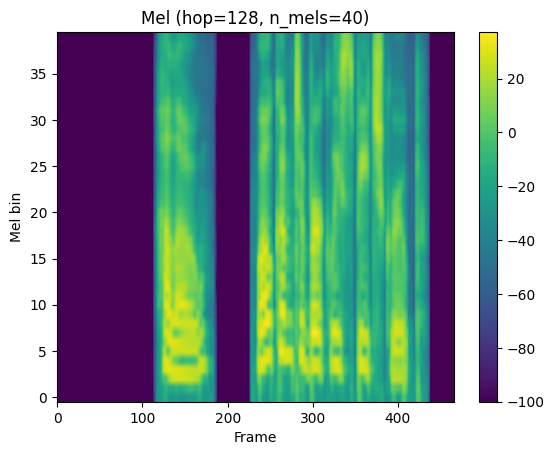

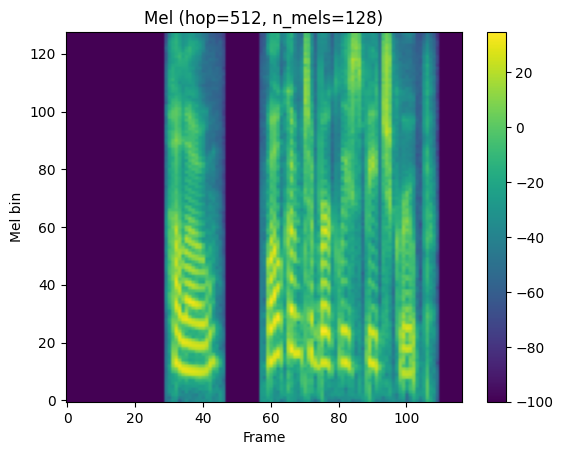

In [8]:

def plot_mel(wave, sr, hop, mels):
    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=1024, hop_length=hop, n_mels=mels
    )(wave)
    mel_db = torchaudio.transforms.AmplitudeToDB()(mel).squeeze().numpy()
    plt.figure()
    plt.imshow(mel_db, origin="lower", aspect="auto")
    plt.xlabel("Frame")
    plt.ylabel("Mel bin")
    plt.title(f"Mel (hop={hop}, n_mels={mels})")
    plt.colorbar()
    plt.show()

plot_mel(wave, sr, hop=128, mels=40)
plot_mel(wave, sr, hop=512, mels=128)



## 6. Speech tokenization (discrete units)

Can we represent audio as **discrete tokens** (like words in text)?

**EnCodec** is a neural audio codec that:
1. **Encodes** audio into discrete token IDs (integers from a codebook)
2. **Decodes** those tokens back into audio waveforms

Think of it like compression: audio → tokens → audio

**Why is this useful?**
- Much smaller representation (seconds of audio → hundreds of tokens)
- Can apply language model techniques to audio
- Used in modern speech generation models (e.g., AudioLM, MusicLM)

**Questions:**
- How is this different from Mel spectrograms?
- What information might be lost in tokenization?
- Can you hear the difference between original and reconstructed audio?

In [9]:

# Step 1: Load EnCodec model
import torch
import torchaudio
from transformers import EncodecModel, AutoProcessor

# Load EnCodec model from Hugging Face (24 kHz version)
enc_model = EncodecModel.from_pretrained("facebook/encodec_24khz").to(device).eval()
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")
enc_sr = processor.sampling_rate

print(f"EnCodec model loaded")
print(f"Model sample rate: {enc_sr} Hz")
print(f"This model will convert audio → discrete tokens → audio")



/home/tinglel/miniconda3/envs/tutor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


EnCodec model loaded
Model sample rate: 24000 Hz
This model will convert audio → discrete tokens → audio


In [10]:
# Step 2: Encode audio to discrete tokens
# Prepare the audio (resample if needed)
wave_for_enc = wave
if sr != enc_sr:
    wave_for_enc = torchaudio.functional.resample(wave, sr, enc_sr)
    print(f"Resampled audio from {sr} Hz to {enc_sr} Hz")

# Pre-process with the processor
inputs = processor(raw_audio=wave_for_enc.squeeze().numpy(), 
                   sampling_rate=enc_sr, 
                   return_tensors="pt")

print(f"Input audio shape: {wave_for_enc.shape}")
print(f"Duration: {wave_for_enc.size(-1) / enc_sr:.2f} seconds")

# Encode: audio waveform → discrete token IDs
with torch.no_grad():
    encoder_outputs = enc_model.encode(inputs["input_values"].to(device), 
                                       inputs["padding_mask"].to(device))
    codes = encoder_outputs.audio_codes.cpu()
    
    # Remove all size-1 dimensions to get [num_codebooks, time_frames]
    codes = codes.squeeze()
    # If still 3D after squeeze, take the first element (batch dimension)
    if codes.ndim == 3:
        codes = codes[0]

print(f"\nAudio encoded to discrete tokens!")
print(f"Token shape: {tuple(codes.shape)}")  # [num_codebooks, time_frames]


Resampled audio from 16000 Hz to 24000 Hz
Input audio shape: torch.Size([1, 89280])
Duration: 3.72 seconds

Audio encoded to discrete tokens!
Token shape: (2, 279)


In [11]:
# Step 3: Visualize the tokens (just like text!)
# These discrete tokens are similar to word IDs in NLP!

import numpy as np
import matplotlib.pyplot as plt

print("Understanding Audio Tokens\n")
print("=" * 60)

# Shape explanation - handle different possible shapes
print(f"Raw codes shape: {codes.shape}")

# Ensure we have [num_codebooks, num_frames] by squeezing extra dimensions
if codes.ndim == 3:
    codes = codes.squeeze(0)  # Remove batch dimension if present
    
num_codebooks, num_frames = codes.shape
print(f"Token shape: [{num_codebooks} codebooks, {num_frames} time frames]")
print(f"  • Each time frame = ~{1000 * wave_for_enc.size(-1) / enc_sr / num_frames:.1f} ms of audio")
print(f"  • Total duration: {wave_for_enc.size(-1) / enc_sr:.2f} seconds")
print(f"  • Compression ratio: {wave_for_enc.size(-1) / num_frames:.1f}x")
print()

# Token statistics
print("Token Statistics:")
for codebook_idx in range(num_codebooks):
    codebook_tokens = codes[codebook_idx].numpy()
    print(f"  Codebook {codebook_idx}: range [{codebook_tokens.min()}, {codebook_tokens.max()}], "
          f"unique tokens: {len(np.unique(codebook_tokens))}")
print()

# Show actual token values (like showing text tokens!)
print("First 20 tokens from Codebook 0 (like text tokens):")
print(codes[0, :20].tolist())


Understanding Audio Tokens

Raw codes shape: torch.Size([2, 279])
Token shape: [2 codebooks, 279 time frames]
  • Each time frame = ~13.3 ms of audio
  • Total duration: 3.72 seconds
  • Compression ratio: 320.0x

Token Statistics:
  Codebook 0: range [3, 1018], unique tokens: 101
  Codebook 1: range [8, 1023], unique tokens: 112

First 20 tokens from Codebook 0 (like text tokens):
[62, 62, 62, 62, 408, 408, 62, 408, 62, 408, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62]


In [12]:
# Step 4: Decode tokens back to audio
# Can we reconstruct audio from just these integer tokens?

with torch.no_grad():
    recon = enc_model.decode(encoder_outputs.audio_codes, 
                             encoder_outputs.audio_scales, 
                             inputs["padding_mask"].to(device))[0].cpu()
    # Remove batch dimension: [batch, channels, time] -> [channels, time]
    recon = recon.squeeze(0)

print(f"Tokens decoded back to audio!")
print(f"Reconstructed audio shape: {tuple(recon.shape)}")
print(f"Sample rate: {enc_sr} Hz")
print(f"\nWe went: Audio → {num_frames} tokens → Audio")
print(f"That's {wave_for_enc.size(-1)} samples → {num_frames} tokens → {recon.size(-1)} samples")


Tokens decoded back to audio!
Reconstructed audio shape: (1, 89280)
Sample rate: 24000 Hz

We went: Audio → 279 tokens → Audio
That's 89280 samples → 279 tokens → 89280 samples


Listen and Compare:

Original audio (resampled to 24kHz):



Reconstructed audio from tokens:


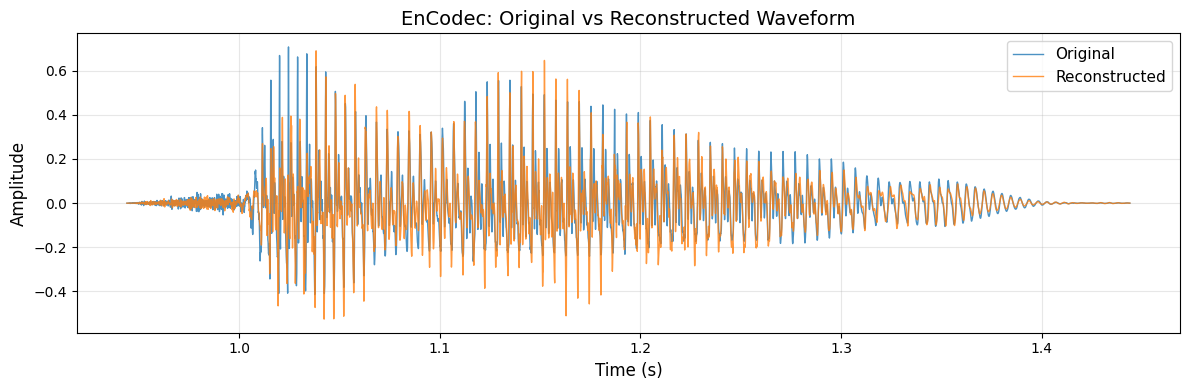

In [13]:
# Step 5: Compare original vs reconstructed audio

from IPython.display import display, Audio

# Save reconstructed audio
torchaudio.save("reconstructed_encodec.wav", recon, enc_sr)

# Listen to both
print("Listen and Compare:\n")
print("Original audio (resampled to 24kHz):")
display(Audio(wave_for_enc.squeeze().cpu().numpy(), rate=enc_sr))

print("\nReconstructed audio from tokens:")
display(Audio(recon.squeeze().cpu().numpy(), rate=enc_sr))

# Visual comparison
import matplotlib.pyplot as plt

x0 = wave_for_enc.squeeze().cpu().numpy()
x1 = recon.squeeze().cpu().numpy()

# Handle multi-channel audio if needed
if x0.ndim == 2:
    x0 = x0[0] if x0.shape[0] < x0.shape[1] else x0[:, 0]
if x1.ndim == 2:
    x1 = x1[0] if x1.shape[0] < x1.shape[1] else x1[:, 0]

# Find a region with audio activity (skip silence)
threshold = 0.01
active_idx = np.where(np.abs(x0) > threshold)[0]
if len(active_idx) > 0:
    start_idx = max(0, active_idx[0] - 200)
else:
    start_idx = 0

# Plot 0.5 seconds
N = min(int(enc_sr * 0.5), len(x0) - start_idx)
time_axis = (start_idx + np.arange(N)) / enc_sr

plt.figure(figsize=(12, 4))
plt.plot(time_axis, x0[start_idx:start_idx+N], label="Original", linewidth=1, alpha=0.8)
plt.plot(time_axis, x1[start_idx:start_idx+N], label="Reconstructed", linewidth=1, alpha=0.8)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.title("EnCodec: Original vs Reconstructed Waveform", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Build a Speech Command Classifier


Now let's build a real audio classifier using everything we've learned!

**Task:** Recognize spoken commands (e.g., "yes", "no", "up", "down", ...)

**Dataset:** Google Speech Commands - 1-second audio clips of people saying 35 different words

**Our Pipeline:**
1. **Preprocessing:** Resample to 16 kHz, convert to mono, pad/crop to 1 second
2. **Feature extraction:** Compute log Mel spectrograms (64 mel bins)
3. **Model:** A simple CNN
4. **Training:** Classify which word was spoken

**Architecture Choice:**
- We use a **CNN** (not just a linear layer) because spectrograms have spatial structure
- Just like images: nearby pixels are related, nearby time-frequency points are related!
- Our CNN has 3 conv blocks that learn hierarchical features

**Questions:**
- Why does the model work better with 2D spectrograms than 1D waveforms?
- What happens if you add more classes? (Try changing `CLASSES` list)
- How does the model perform on validation vs training? (Watch for overfitting!)
- What could you do to improve accuracy?


In [14]:

import os
import torch
import torch.nn.functional as F
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
from typing import List, Tuple

# Configuration
# Try changing these to experiment!
CLASSES = ["yes", "no"]  # Try: ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
N_MELS = 64              # Number of mel frequency bins
HOP = 256                # Hop length for spectrogram

class SpeechCommandsSubset(torch.utils.data.Dataset):
    """
    Dataset for a subset of classes from Google Speech Commands.
    Automatically handles train/validation/test splits.
    """
    def __init__(
        self, 
        root: str, 
        split: str = "training", 
        classes: List[str] = CLASSES,
        target_sr: int = TARGET_SR,
        target_duration: float = 1.0,  # seconds
        n_mels: int = N_MELS,
        hop_length: int = HOP
    ):
        super().__init__()
        self.root = root
        self.target_sr = target_sr
        self.target_samples = int(target_sr * target_duration)
        self.cls2idx = {c: i for i, c in enumerate(classes)}
        
        # Initialize transforms (no global variables!)
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=target_sr,
            n_fft=1024,
            hop_length=hop_length,
            n_mels=n_mels
        )
        
        # Load dataset
        self.items: List[Tuple[str, int]] = []
        self._load_dataset(split)
    
    def _load_dataset(self, split: str):
        """Load and filter dataset based on split and classes."""
        try:
            # Try using torchaudio's subset API
            ds = SPEECHCOMMANDS(root=self.root, download=True, subset=split)
            for i in range(len(ds)):
                _, _, label, _, _ = ds[i]
                if label in self.cls2idx:
                    self.items.append((ds._walker[i], self.cls2idx[label]))
            self.base_dataset = ds
            self.uses_subset_api = True
        except TypeError:
            # Fallback: manually handle splits using text files
            ds = SPEECHCOMMANDS(root=self.root, download=True)
            self.base_dataset = ds
            self.uses_subset_api = False
            
            # Load split files
            valid_list = self._load_split_file(ds._path, "validation_list.txt")
            test_list = self._load_split_file(ds._path, "testing_list.txt")
            
            # Filter samples based on split and classes
            for relpath in ds._walker:
                label = relpath.split(os.sep)[0]
                if label not in self.cls2idx:
                    continue
                
                # Determine if this sample belongs to the requested split
                in_valid = relpath in valid_list
                in_test = relpath in test_list
                
                if (split == "validation" and in_valid) or \
                   (split == "testing" and in_test) or \
                   (split == "training" and not in_valid and not in_test):
                    self.items.append((relpath, self.cls2idx[label]))
    
    @staticmethod
    def _load_split_file(base_path: str, filename: str) -> set:
        """Load split file containing relative paths."""
        for possible_path in [
            os.path.join(base_path, "SpeechCommands", filename),
            os.path.join(base_path, filename)
        ]:
            if os.path.exists(possible_path):
                with open(possible_path, "r") as f:
                    return set(line.strip() for line in f)
        return set()
    
    def _preprocess_audio(self, wav: torch.Tensor, sr: int) -> torch.Tensor:
        """Resample, convert to mono, and pad/crop to target length."""
        # Convert to mono
        if wav.size(0) > 1:
            wav = wav.mean(dim=0, keepdim=True)
        
        # Resample if needed
        if sr != self.target_sr:
            wav = torchaudio.functional.resample(wav, sr, self.target_sr)
        
        # Pad or crop to target length
        current_len = wav.size(-1)
        if current_len < self.target_samples:
            wav = F.pad(wav, (0, self.target_samples - current_len))
        else:
            wav = wav[..., :self.target_samples]
        
        return wav
    
    def _compute_features(self, wav: torch.Tensor) -> torch.Tensor:
        """Convert waveform to log mel spectrogram features."""
        mel = self.mel_spec(wav)  # [1, n_mels, time_frames]
        # Take log for better feature representation (avoid log(0))
        mel_log = torch.log(mel + 1e-9)
        # Return 2D spectrogram for CNN: [1, n_mels, time_frames]
        return mel_log
    
    def __len__(self) -> int:
        return len(self.items)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        relpath, label = self.items[idx]
        
        # Load audio
        if self.uses_subset_api:
            wav, sr, _, _, _ = self.base_dataset[idx]
        else:
            path = os.path.join(self.base_dataset._path, relpath)
            wav, sr = torchaudio.load(path)
        
        # Preprocess and extract features
        wav = self._preprocess_audio(wav, sr)
        features = self._compute_features(wav)
        
        return features, torch.tensor(label, dtype=torch.long)


In [15]:

from torch.utils.data import DataLoader

root = "./data"
batch_size = 64

# Create data directory if it doesn't exist
os.makedirs(root, exist_ok=True)

train_set = SpeechCommandsSubset(root, "training", CLASSES)
valid_set = SpeechCommandsSubset(root, "validation", CLASSES)

print("Train size:", len(train_set), "Valid size:", len(valid_set), "Classes:", CLASSES)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=False)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)


Train size: 6358 Valid size: 803 Classes: ['yes', 'no']


In [16]:
# Listen to an example audio file
import glob
from IPython.display import display

# Find a "yes" example from the dataset
yes_files = glob.glob(f"{root}/SpeechCommands/speech_commands_v0.02/yes/*.wav")
example_file = yes_files[0]
print(f"Loading example: {example_file}")

# Load and play the audio
wav, sr = torchaudio.load(example_file)
print(f"Original audio: shape={wav.shape}, sample_rate={sr}")

# Resample to 16kHz if needed
if sr != TARGET_SR:
    wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
    sr = TARGET_SR

# Convert to mono if stereo
if wav.size(0) > 1:
    wav = wav.mean(dim=0, keepdim=True)

print(f"Processed audio: shape={wav.shape}, sample_rate={sr}")
display(Audio(wav.squeeze().numpy(), rate=sr))

Loading example: ./data/SpeechCommands/speech_commands_v0.02/yes/f5626af6_nohash_3.wav
Original audio: shape=torch.Size([1, 16000]), sample_rate=16000
Processed audio: shape=torch.Size([1, 16000]), sample_rate=16000


In [17]:

# Define our CNN model

import torch.nn as nn

class SimpleCNN(nn.Module):
    """
    Lighter CNN for audio classification to reduce overfitting.
    Input: [batch, 1, n_mels, time_frames]
    Output: [batch, num_classes]
    """
    def __init__(self, num_classes: int = len(CLASSES)):
        super().__init__()
        
        # Convolutional layers (reduced channels: 16 -> 32 -> 64)
        self.conv_layers = nn.Sequential(
            # Conv block 1
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [batch, 16, n_mels/2, time/2]
            
            # Conv block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [batch, 32, n_mels/4, time/4]
            
            # Conv block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # [batch, 64, 1, 1]
        )
        
        # Simpler fully connected layer (direct to output)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [batch, 1, n_mels, time_frames]
        Returns:
            logits: [batch, num_classes]
        """
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model with smaller capacity and lower learning rate
model = SimpleCNN(num_classes=len(CLASSES)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)  # Lower LR + L2 regularization
criterion = nn.CrossEntropyLoss()

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

def run_epoch(loader, train: bool = True):
    """Run one epoch of training or evaluation."""
    model.train(train)
    total_loss = 0.0
    correct = 0
    total = 0
    
    for features, labels in loader:
        features = features.to(device)  # [batch, 1, n_mels, time]
        labels = labels.to(device)      # [batch]
        
        # Forward pass
        logits = model(features)
        loss = criterion(logits, labels)
        
        # Backward pass (only in training)
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Statistics
        total_loss += loss.item() * features.size(0)
        predictions = logits.argmax(dim=-1)
        correct += (predictions == labels).sum().item()
        total += features.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Training loop
EPOCHS = 10  # Try increasing to 20-30 for better results

print(f"Training for {EPOCHS} epochs...")

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    valid_loss, valid_acc = run_epoch(valid_loader, train=False)
    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"valid loss {valid_loss:.4f} acc {valid_acc:.3f}")


Model has 23,650 parameters
Training for 10 epochs...
Epoch 01 | train loss 0.6786 acc 0.573 | valid loss 0.6822 acc 0.572
Epoch 02 | train loss 0.6287 acc 0.653 | valid loss 0.6727 acc 0.559
Epoch 03 | train loss 0.5826 acc 0.699 | valid loss 0.7841 acc 0.513
Epoch 04 | train loss 0.5402 acc 0.730 | valid loss 0.5637 acc 0.719
Epoch 05 | train loss 0.5129 acc 0.754 | valid loss 0.5824 acc 0.689
Epoch 06 | train loss 0.4839 acc 0.775 | valid loss 0.5226 acc 0.766
Epoch 07 | train loss 0.4677 acc 0.783 | valid loss 0.5394 acc 0.755
Epoch 08 | train loss 0.4422 acc 0.794 | valid loss 0.4964 acc 0.770
Epoch 09 | train loss 0.4285 acc 0.808 | valid loss 0.5027 acc 0.777
Epoch 10 | train loss 0.4289 acc 0.810 | valid loss 0.4786 acc 0.791


In [18]:

# Let's see how the model performs on a batch from validation set
# This shows the model's predictions vs. actual labels

model.eval()
features_batch, labels_batch = next(iter(valid_loader))
with torch.no_grad():
    logits = model(features_batch.to(device))
pred = logits.argmax(dim=-1).cpu().tolist()

print("CLASSES:", CLASSES)
for i in range(min(10, len(pred))):
    print(f"sample {i:02d} | pred={CLASSES[pred[i]]} | true={CLASSES[labels_batch[i]]}")


CLASSES: ['yes', 'no']
sample 00 | pred=no | true=no
sample 01 | pred=no | true=no
sample 02 | pred=no | true=no
sample 03 | pred=no | true=no
sample 04 | pred=no | true=no
sample 05 | pred=yes | true=no
sample 06 | pred=no | true=no
sample 07 | pred=no | true=no
sample 08 | pred=no | true=no
sample 09 | pred=no | true=no


In [40]:
# Test the model on a specific audio file
import glob
import random

# Load a "no" example to test
no_files = glob.glob(f"{root}/SpeechCommands/speech_commands_v0.02/no/*.wav")
test_file = random.choice(no_files)
print(f"Testing on: {test_file}")

# Load and preprocess audio
wav, sr = torchaudio.load(test_file)
if sr != TARGET_SR:
    wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
if wav.size(0) > 1:
    wav = wav.mean(dim=0, keepdim=True)

# Pad or crop to 1 second
target_samples = int(TARGET_SR * 1.0)
if wav.size(-1) < target_samples:
    wav = F.pad(wav, (0, target_samples - wav.size(-1)))
else:
    wav = wav[..., :target_samples]

# Compute features (same as in dataset)
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=TARGET_SR, n_fft=1024, hop_length=HOP, n_mels=N_MELS
)
mel = mel_spec(wav)
features = torch.log(mel + 1e-9).unsqueeze(0)  # Add batch dimension

# Make prediction
model.eval()
with torch.no_grad():
    logits = model(features.to(device))
    pred_idx = logits.argmax(dim=-1).item()

print(f"\nPrediction: {CLASSES[pred_idx]}")
print(f"True label: no")
print(f"Confidence: {torch.softmax(logits, dim=-1)[0, pred_idx].item():.2%}")

# Listen to the audio
display(Audio(wav.squeeze().numpy(), rate=TARGET_SR))


Testing on: ./data/SpeechCommands/speech_commands_v0.02/no/74241b28_nohash_2.wav

Prediction: no
True label: no
Confidence: 81.04%
